# Nested Sampling with JAX-bandflux on Google Colab

This notebook demonstrates how to run the nested sampling procedure for supernovae SALT model fitting using the JAX-bandflux package (as implemented in `ns.py`). We will install the package, load the data, set up and run the nested sampling algorithm, and finally produce a corner plot of the posterior samples.

For more examples and the complete codebase, visit the [JAX-bandflux GitHub repository](https://github.com/samleeney/JAX-bandflux). The academic paper associated with this work can be found [here](https://github.com/samleeney/JAX-bandflux/blob/71ca8d1b3b273147e1e9bf60a9ef11a806363b80/paper.bib).

In [7]:
# Install JAX-bandflux and its dependencies
!pip install jax-bandflux

# Install BlackjaxNS and distrax
!pip install git+https://github.com/handley-lab/blackjax@nested_sampling
!pip install git+https://github.com/google-deepmind/distrax

# Additional dependencies
!pip install jax jaxlib anesthetic matplotlib tqdm

/usr/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try 'pacman -S
    python-xyz', where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Arch-packaged Python package,
    create a virtual environment using 'python -m venv path/to/venv'.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip.
    
    If you wish to install a non-Arch packaged Python application,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. Make sure you have python-pipx
    installed via pacman.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detailed specification.
error: externally-managed-environment

× This environment is externally managed
╰

## Importing Libraries and Loading Data

In this section, we import the required libraries and load the supernova light curve data using the function `load_and_process_data`. This function will also register the required bandpasses, process the data, and prepare it for modelling.

In [8]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from blackjax.ns.utils import log_weights
from jax_supernovae.salt3 import optimized_salt3_multiband_flux
from jax_supernovae.data import load_and_process_data
from jax_supernovae.bandpasses import register_bandpass, get_bandpass, register_all_bandpasses
from jax_supernovae.utils import save_chains_dead_birth
from anesthetic import read_chains, make_2d_axes
import os

# Set flag to use fixed redshift
fix_z = True

# Load and process the data (ensure your data files are in the 'data' directory)
times, fluxes, fluxerrs, zps, band_indices, bridges, fixed_z = load_and_process_data('19dwz', data_dir='data', fix_z=fix_z)

print('Data loaded:')
print('Observation times shape:', times.shape)
print('Flux measurements shape:', fluxes.shape)

Loading data from /home/sam/academic/sn_anomaly2/jax_supernovae/data/19dwz/all.phot


Data loaded:
Observation times shape: (33,)
Flux measurements shape: (33,)


## Setting Up the Nested Sampling Algorithm

Here we define the necessary functions for nested sampling. These include the log prior and log likelihood functions, which will be utilised by the sampling algorithm from Blackjax. The parameters being fitted are `t0`, `x0` (expressed in log scale), `x1`, `c` and optionally `log_sigma`. Prior bounds and distributions are defined accordingly.

### Nested sampling settings
On a GPU, you might consider setting 'n_delete' to a value close to n_live/2, e.g.,
`NS_SETTINGS['n_delete'] = NS_SETTINGS['n_live'] // 2`. This change can substantially speedup the nested sampling algorithm.

In [9]:
# Nested sampling settings
NS_SETTINGS = {
    'max_iterations': int(os.environ.get('NS_MAX_ITERATIONS', '5000')),
    'n_delete': 1,
    'n_live': 125,
    'num_mcmc_steps_multiplier': 5
}


### Setup prior bounds and distributions
In this section, we define the prior bounds and distributions for our SALT3 model parameters. The priors are uniform distributions over physically meaningful ranges for each parameter. For fixed redshift cases, we fit for `t0` (time of peak brightness), `x0` (overall amplitude), `x1` (light curve stretch), and `c` (colour). When redshift is not fixed, we also fit for `z` (redshift).

In [10]:
import os
import distrax
import blackjax

# Define prior bounds for parameters
PRIOR_BOUNDS = {
    't0': {'min': 58000.0, 'max': 59000.0},
    'x0': {'min': -5.0, 'max': -2.6},
    'x1': {'min': -4.0, 'max': 4.0},
    'c': {'min': -0.3, 'max': 0.3},
    'log_sigma': {'min': -3.0, 'max': 1.0}
}

# Set whether to fit sigma (extra free parameter)
fit_sigma = False

if fix_z:
    param_bounds = {
        't0': (PRIOR_BOUNDS['t0']['min'], PRIOR_BOUNDS['t0']['max']),
        'x0': (PRIOR_BOUNDS['x0']['min'], PRIOR_BOUNDS['x0']['max']),
        'x1': (PRIOR_BOUNDS['x1']['min'], PRIOR_BOUNDS['x1']['max']),
        'c': (PRIOR_BOUNDS['c']['min'], PRIOR_BOUNDS['c']['max'])
    }
    if fit_sigma:
        param_bounds['log_sigma'] = (PRIOR_BOUNDS['log_sigma']['min'], PRIOR_BOUNDS['log_sigma']['max'])
    prior_dists = {
        't0': distrax.Uniform(low=param_bounds['t0'][0], high=param_bounds['t0'][1]),
        'x0': distrax.Uniform(low=param_bounds['x0'][0], high=param_bounds['x0'][1]),
        'x1': distrax.Uniform(low=param_bounds['x1'][0], high=param_bounds['x1'][1]),
        'c': distrax.Uniform(low=param_bounds['c'][0], high=param_bounds['c'][1])
    }
    if fit_sigma:
        prior_dists['log_sigma'] = distrax.Uniform(low=param_bounds['log_sigma'][0], high=param_bounds['log_sigma'][1])
else:
    param_bounds = {
        'z': (0.001, 0.2),
        't0': (PRIOR_BOUNDS['t0']['min'], PRIOR_BOUNDS['t0']['max']),
        'x0': (PRIOR_BOUNDS['x0']['min'], PRIOR_BOUNDS['x0']['max']),
        'x1': (PRIOR_BOUNDS['x1']['min'], PRIOR_BOUNDS['x1']['max']),
        'c': (PRIOR_BOUNDS['c']['min'], PRIOR_BOUNDS['c']['max'])
    }
    if fit_sigma:
        param_bounds['log_sigma'] = (PRIOR_BOUNDS['log_sigma']['min'], PRIOR_BOUNDS['log_sigma']['max'])
    prior_dists = {
        'z': distrax.Uniform(low=param_bounds['z'][0], high=param_bounds['z'][1]),
        't0': distrax.Uniform(low=param_bounds['t0'][0], high=param_bounds['t0'][1]),
        'x0': distrax.Uniform(low=param_bounds['x0'][0], high=param_bounds['x0'][1]),
        'x1': distrax.Uniform(low=param_bounds['x1'][0], high=param_bounds['x1'][1]),
        'c': distrax.Uniform(low=param_bounds['c'][0], high=param_bounds['c'][1])
    }
    if fit_sigma:
        prior_dists['log_sigma'] = distrax.Uniform(low=param_bounds['log_sigma'][0], high=param_bounds['log_sigma'][1])

# Define the log prior function
@jax.jit
def logprior(params):
    params = jnp.atleast_2d(params)
    if fix_z:
        if fit_sigma:
            logp = (prior_dists['t0'].log_prob(params[:, 0]) +
                    prior_dists['x0'].log_prob(params[:, 1]) +
                    prior_dists['x1'].log_prob(params[:, 2]) +
                    prior_dists['c'].log_prob(params[:, 3]) +
                    prior_dists['log_sigma'].log_prob(params[:, 4]))
        else:
            logp = (prior_dists['t0'].log_prob(params[:, 0]) +
                    prior_dists['x0'].log_prob(params[:, 1]) +
                    prior_dists['x1'].log_prob(params[:, 2]) +
                    prior_dists['c'].log_prob(params[:, 3]))
    else:
        if fit_sigma:
            logp = (prior_dists['z'].log_prob(params[:, 0]) +
                    prior_dists['t0'].log_prob(params[:, 1]) +
                    prior_dists['x0'].log_prob(params[:, 2]) +
                    prior_dists['x1'].log_prob(params[:, 3]) +
                    prior_dists['c'].log_prob(params[:, 4]) +
                    prior_dists['log_sigma'].log_prob(params[:, 5]))
        else:
            logp = (prior_dists['z'].log_prob(params[:, 0]) +
                    prior_dists['t0'].log_prob(params[:, 1]) +
                    prior_dists['x0'].log_prob(params[:, 2]) +
                    prior_dists['x1'].log_prob(params[:, 3]) +
                    prior_dists['c'].log_prob(params[:, 4]))
    return jnp.reshape(logp, (-1,))

# Define the log likelihood functions
@jax.jit
def compute_single_loglikelihood(params):
    if fix_z:
        if fit_sigma:
            t0, log_x0, x1, c, log_sigma = params
            sigma = 10 ** log_sigma
        else:
            t0, log_x0, x1, c = params
            sigma = 1.0
        z = fixed_z[0]
    else:
        if fit_sigma:
            z, t0, log_x0, x1, c, log_sigma = params
            sigma = 10 ** log_sigma
        else:
            z, t0, log_x0, x1, c = params
            sigma = 1.0
    x0 = 10 ** log_x0
    param_dict = {'z': z, 't0': t0, 'x0': x0, 'x1': x1, 'c': c}
    model_fluxes = optimized_salt3_multiband_flux(times, bridges, param_dict, zps=zps, zpsys='ab')
    model_fluxes = model_fluxes[jnp.arange(len(times)), band_indices]
    eff_fluxerrs = sigma * fluxerrs
    chi2 = jnp.sum(((fluxes - model_fluxes) / eff_fluxerrs) ** 2)
    log_likelihood = -0.5 * (chi2 + jnp.sum(jnp.log(2 * jnp.pi * eff_fluxerrs ** 2)))
    return log_likelihood

@jax.jit
def compute_batch_loglikelihood(params):
    params = jnp.atleast_2d(params)
    batch_loglike = jax.vmap(compute_single_loglikelihood)(params)
    return jnp.reshape(batch_loglike, (-1,))

@jax.jit
def loglikelihood(params):
    params = jnp.atleast_2d(params)
    return compute_batch_loglikelihood(params)

def sample_from_priors(rng_key, n_samples):
    if fix_z:
        if fit_sigma:
            keys = jax.random.split(rng_key, 5)
            return jnp.column_stack([
                prior_dists['t0'].sample(seed=keys[0], sample_shape=(n_samples,)),
                prior_dists['x0'].sample(seed=keys[1], sample_shape=(n_samples,)),
                prior_dists['x1'].sample(seed=keys[2], sample_shape=(n_samples,)),
                prior_dists['c'].sample(seed=keys[3], sample_shape=(n_samples,)),
                prior_dists['log_sigma'].sample(seed=keys[4], sample_shape=(n_samples,))
            ])
        else:
            keys = jax.random.split(rng_key, 4)
            return jnp.column_stack([
                prior_dists['t0'].sample(seed=keys[0], sample_shape=(n_samples,)),
                prior_dists['x0'].sample(seed=keys[1], sample_shape=(n_samples,)),
                prior_dists['x1'].sample(seed=keys[2], sample_shape=(n_samples,)),
                prior_dists['c'].sample(seed=keys[3], sample_shape=(n_samples,))
            ])
    else:
        if fit_sigma:
            keys = jax.random.split(rng_key, 6)
            return jnp.column_stack([
                prior_dists['z'].sample(seed=keys[0], sample_shape=(n_samples,)),
                prior_dists['t0'].sample(seed=keys[1], sample_shape=(n_samples,)),
                prior_dists['x0'].sample(seed=keys[2], sample_shape=(n_samples,)),
                prior_dists['x1'].sample(seed=keys[3], sample_shape=(n_samples,)),
                prior_dists['c'].sample(seed=keys[4], sample_shape=(n_samples,)),
                prior_dists['log_sigma'].sample(seed=keys[5], sample_shape=(n_samples,))
            ])
        else:
            keys = jax.random.split(rng_key, 5)
            return jnp.column_stack([
                prior_dists['z'].sample(seed=keys[0], sample_shape=(n_samples,)),
                prior_dists['t0'].sample(seed=keys[1], sample_shape=(n_samples,)),
                prior_dists['x0'].sample(seed=keys[2], sample_shape=(n_samples,)),
                prior_dists['x1'].sample(seed=keys[3], sample_shape=(n_samples,)),
                prior_dists['c'].sample(seed=keys[4], sample_shape=(n_samples,))
            ])

if fix_z:
    n_params_total = 4
else:
    n_params_total = 5
if fit_sigma:
    n_params_total += 1

### Initialise the nested sampling algorithm

In [11]:
num_mcmc_steps = n_params_total * NS_SETTINGS['num_mcmc_steps_multiplier']

# Initialise the nested sampling algorithm using Blackjax
print("Setting up nested sampling algorithm...")
algo = blackjax.ns.adaptive.nss(
    logprior_fn=logprior,
    loglikelihood_fn=loglikelihood,
    n_delete=NS_SETTINGS['n_delete'],
    num_mcmc_steps=num_mcmc_steps
)

# Initialise random key and generate initial particles
rng_key = jax.random.PRNGKey(0)
rng_key, init_key = jax.random.split(rng_key)

initial_particles = sample_from_priors(init_key, NS_SETTINGS['n_live'])
print("Initial particles generated, shape:", initial_particles.shape)

# Initialise the sampler state
state = algo.init(initial_particles, compute_batch_loglikelihood)

# Define a one-step function for the nested sampling (JIT compiled for efficiency)
@jax.jit
def one_step(carry, xs):
    state, k = carry
    k, subk = jax.random.split(k, 2)
    state, dead_point = algo.step(subk, state)
    return (state, k), dead_point

Setting up nested sampling algorithm...
Initial particles generated, shape: (125, 4)


## Running the Nested Sampling

Now we run the nested sampling algorithm for a specified number of iterations. The loop stops if the evidence of the live points is sufficiently lower than that of the dead points. Progress is printed every 10 iterations.

In [12]:
dead = []
num_iterations = NS_SETTINGS['max_iterations']

print("Running nested sampling...")
for i in tqdm.trange(num_iterations):
    if state.sampler_state.logZ_live - state.sampler_state.logZ < -3:
        break

    (state, rng_key), dead_info = one_step((state, rng_key), None)
    dead.append(dead_info)

    if i % 10 == 0:
        print(f"Iteration {i}: logZ = {state.sampler_state.logZ:.2f}")

# Combine dead points and compute log evidence
dead = jax.tree_map(lambda *args: jnp.concatenate(args), *dead)
logw = log_weights(rng_key, dead)
logZs = jax.scipy.special.logsumexp(logw, axis=0)

print(f"Runtime evidence: {state.sampler_state.logZ:.2f}")
print(f"Estimated evidence: {logZs.mean():.2f} ± {logZs.std():.2f}")


Running nested sampling...


  0%|          | 1/5000 [00:33<46:40:43, 33.62s/it]

Iteration 0: logZ = -3641.00


  0%|          | 13/5000 [01:08<45:34,  1.82it/s]  

Iteration 10: logZ = -1125.05


  0%|          | 23/5000 [01:10<15:42,  5.28it/s]

Iteration 20: logZ = -1124.27


  1%|          | 33/5000 [01:11<14:46,  5.60it/s]

Iteration 30: logZ = -1123.87


  1%|          | 41/5000 [01:13<21:06,  3.91it/s]

Iteration 40: logZ = -1123.60


  1%|          | 51/5000 [01:15<19:47,  4.17it/s]

Iteration 50: logZ = -1123.41


  1%|          | 61/5000 [01:17<20:38,  3.99it/s]

Iteration 60: logZ = -1123.26


  1%|▏         | 71/5000 [01:19<23:15,  3.53it/s]

Iteration 70: logZ = -1123.13


  2%|▏         | 81/5000 [01:21<22:27,  3.65it/s]

Iteration 80: logZ = -1123.03


  2%|▏         | 93/5000 [01:24<14:36,  5.60it/s]

Iteration 90: logZ = -1122.95


  2%|▏         | 103/5000 [01:26<15:06,  5.40it/s]

Iteration 100: logZ = -1122.87


  2%|▏         | 113/5000 [01:28<14:40,  5.55it/s]

Iteration 110: logZ = -1122.81


  2%|▏         | 121/5000 [01:29<21:39,  3.76it/s]

Iteration 120: logZ = -1122.75


  3%|▎         | 131/5000 [01:32<22:49,  3.56it/s]

Iteration 130: logZ = -1122.69


  3%|▎         | 141/5000 [01:34<20:47,  3.90it/s]

Iteration 140: logZ = -1122.57


  3%|▎         | 151/5000 [01:36<22:03,  3.66it/s]

Iteration 150: logZ = -1122.40


  3%|▎         | 161/5000 [01:38<21:53,  3.68it/s]

Iteration 160: logZ = -1122.06


  3%|▎         | 173/5000 [01:40<14:44,  5.46it/s]

Iteration 170: logZ = -1120.59


  4%|▎         | 181/5000 [01:42<22:24,  3.58it/s]

Iteration 180: logZ = -1118.38


  4%|▍         | 191/5000 [01:44<20:43,  3.87it/s]

Iteration 190: logZ = -1115.40


  4%|▍         | 203/5000 [01:47<15:40,  5.10it/s]

Iteration 200: logZ = -1112.72


  4%|▍         | 213/5000 [01:49<16:04,  4.96it/s]

Iteration 210: logZ = -1108.33


  4%|▍         | 223/5000 [01:51<14:32,  5.47it/s]

Iteration 220: logZ = -1103.85


  5%|▍         | 231/5000 [01:53<20:17,  3.92it/s]

Iteration 230: logZ = -1099.01


  5%|▍         | 241/5000 [01:55<20:52,  3.80it/s]

Iteration 240: logZ = -1090.75


  5%|▌         | 253/5000 [01:58<18:40,  4.24it/s]

Iteration 250: logZ = -1082.83


  5%|▌         | 263/5000 [02:01<15:57,  4.95it/s]

Iteration 260: logZ = -1077.48


  5%|▌         | 271/5000 [02:02<20:51,  3.78it/s]

Iteration 270: logZ = -1069.21


  6%|▌         | 281/5000 [02:05<20:42,  3.80it/s]

Iteration 280: logZ = -1056.84


  6%|▌         | 291/5000 [02:07<20:39,  3.80it/s]

Iteration 290: logZ = -1052.70


  6%|▌         | 303/5000 [02:09<14:38,  5.35it/s]

Iteration 300: logZ = -1046.45


  6%|▌         | 311/5000 [02:11<20:49,  3.75it/s]

Iteration 310: logZ = -1035.06


  6%|▋         | 321/5000 [02:13<22:47,  3.42it/s]

Iteration 320: logZ = -1024.20


  7%|▋         | 331/5000 [02:15<20:27,  3.80it/s]

Iteration 330: logZ = -1012.27


  7%|▋         | 343/5000 [02:18<16:10,  4.80it/s]

Iteration 340: logZ = -1003.93


  7%|▋         | 353/5000 [02:20<15:00,  5.16it/s]

Iteration 350: logZ = -991.81


  7%|▋         | 361/5000 [02:22<21:39,  3.57it/s]

Iteration 360: logZ = -964.04


  7%|▋         | 371/5000 [02:24<20:37,  3.74it/s]

Iteration 370: logZ = -949.44


  8%|▊         | 381/5000 [02:26<20:42,  3.72it/s]

Iteration 380: logZ = -931.09


  8%|▊         | 391/5000 [02:28<20:40,  3.72it/s]

Iteration 390: logZ = -895.72


  8%|▊         | 403/5000 [02:31<14:45,  5.19it/s]

Iteration 400: logZ = -842.99


  8%|▊         | 411/5000 [02:33<22:50,  3.35it/s]

Iteration 410: logZ = -815.30


  8%|▊         | 421/5000 [02:35<20:48,  3.67it/s]

Iteration 420: logZ = -776.34


  9%|▊         | 431/5000 [02:37<20:14,  3.76it/s]

Iteration 430: logZ = -751.89


  9%|▉         | 443/5000 [02:39<15:36,  4.87it/s]

Iteration 440: logZ = -724.78


  9%|▉         | 451/5000 [02:41<20:11,  3.76it/s]

Iteration 450: logZ = -701.50


  9%|▉         | 461/5000 [02:43<20:07,  3.76it/s]

Iteration 460: logZ = -664.37


  9%|▉         | 471/5000 [02:45<20:09,  3.74it/s]

Iteration 470: logZ = -650.63


 10%|▉         | 481/5000 [02:47<19:33,  3.85it/s]

Iteration 480: logZ = -609.06


 10%|▉         | 491/5000 [02:49<19:54,  3.78it/s]

Iteration 490: logZ = -583.18


 10%|█         | 501/5000 [02:52<20:19,  3.69it/s]

Iteration 500: logZ = -567.21


 10%|█         | 511/5000 [02:54<20:15,  3.69it/s]

Iteration 510: logZ = -533.73


 10%|█         | 523/5000 [02:56<14:39,  5.09it/s]

Iteration 520: logZ = -510.61


 11%|█         | 531/5000 [02:58<20:29,  3.64it/s]

Iteration 530: logZ = -495.35


 11%|█         | 543/5000 [03:00<13:38,  5.45it/s]

Iteration 540: logZ = -473.13


 11%|█         | 551/5000 [03:02<19:56,  3.72it/s]

Iteration 550: logZ = -453.53


 11%|█         | 561/5000 [03:04<19:54,  3.72it/s]

Iteration 560: logZ = -439.59


 11%|█▏        | 571/5000 [03:06<19:24,  3.80it/s]

Iteration 570: logZ = -428.28


 12%|█▏        | 581/5000 [03:08<20:19,  3.62it/s]

Iteration 580: logZ = -398.54


 12%|█▏        | 591/5000 [03:11<19:08,  3.84it/s]

Iteration 590: logZ = -386.02


 12%|█▏        | 601/5000 [03:13<20:20,  3.60it/s]

Iteration 600: logZ = -373.01


 12%|█▏        | 611/5000 [03:15<21:07,  3.46it/s]

Iteration 610: logZ = -364.14


 12%|█▏        | 621/5000 [03:17<20:36,  3.54it/s]

Iteration 620: logZ = -347.38


 13%|█▎        | 631/5000 [03:19<19:47,  3.68it/s]

Iteration 630: logZ = -334.47


 13%|█▎        | 641/5000 [03:21<20:35,  3.53it/s]

Iteration 640: logZ = -323.57


 13%|█▎        | 651/5000 [03:24<20:41,  3.50it/s]

Iteration 650: logZ = -308.96


 13%|█▎        | 661/5000 [03:26<18:29,  3.91it/s]

Iteration 660: logZ = -298.17


 13%|█▎        | 671/5000 [03:28<19:55,  3.62it/s]

Iteration 670: logZ = -291.77


 14%|█▎        | 681/5000 [03:30<19:54,  3.62it/s]

Iteration 680: logZ = -283.47


 14%|█▍        | 691/5000 [03:32<19:34,  3.67it/s]

Iteration 690: logZ = -274.97


 14%|█▍        | 701/5000 [03:34<20:53,  3.43it/s]

Iteration 700: logZ = -268.76


 14%|█▍        | 711/5000 [03:37<19:39,  3.64it/s]

Iteration 710: logZ = -260.15


 14%|█▍        | 721/5000 [03:39<19:03,  3.74it/s]

Iteration 720: logZ = -255.54


 15%|█▍        | 731/5000 [03:41<19:22,  3.67it/s]

Iteration 730: logZ = -245.46


 15%|█▍        | 741/5000 [03:43<18:55,  3.75it/s]

Iteration 740: logZ = -237.75


 15%|█▌        | 753/5000 [03:45<13:44,  5.15it/s]

Iteration 750: logZ = -233.33


 15%|█▌        | 761/5000 [03:47<18:14,  3.87it/s]

Iteration 760: logZ = -228.45


 15%|█▌        | 773/5000 [03:49<13:34,  5.19it/s]

Iteration 770: logZ = -222.17


 16%|█▌        | 781/5000 [03:51<19:29,  3.61it/s]

Iteration 780: logZ = -218.18


 16%|█▌        | 791/5000 [03:54<19:47,  3.54it/s]

Iteration 790: logZ = -214.47


 16%|█▌        | 803/5000 [03:56<13:16,  5.27it/s]

Iteration 800: logZ = -212.69


 16%|█▌        | 811/5000 [03:58<20:45,  3.36it/s]

Iteration 810: logZ = -210.14


 16%|█▋        | 821/5000 [04:00<18:33,  3.75it/s]

Iteration 820: logZ = -208.58


 17%|█▋        | 831/5000 [04:02<19:10,  3.62it/s]

Iteration 830: logZ = -206.20


 17%|█▋        | 841/5000 [04:04<19:58,  3.47it/s]

Iteration 840: logZ = -202.96


 17%|█▋        | 851/5000 [04:07<19:44,  3.50it/s]

Iteration 850: logZ = -200.68


 17%|█▋        | 863/5000 [04:09<13:04,  5.27it/s]

Iteration 860: logZ = -198.87


 17%|█▋        | 871/5000 [04:11<19:44,  3.49it/s]

Iteration 870: logZ = -197.12


 18%|█▊        | 883/5000 [04:13<13:05,  5.24it/s]

Iteration 880: logZ = -195.23


 18%|█▊        | 891/5000 [04:15<20:26,  3.35it/s]

Iteration 890: logZ = -193.28


 18%|█▊        | 901/5000 [04:17<18:40,  3.66it/s]

Iteration 900: logZ = -191.67


 18%|█▊        | 911/5000 [04:19<18:21,  3.71it/s]

Iteration 910: logZ = -190.30


 18%|█▊        | 921/5000 [04:21<17:48,  3.82it/s]

Iteration 920: logZ = -189.28


 19%|█▊        | 931/5000 [04:23<17:25,  3.89it/s]

Iteration 930: logZ = -188.23


 19%|█▉        | 941/5000 [04:26<17:25,  3.88it/s]

Iteration 940: logZ = -186.80


 19%|█▉        | 953/5000 [04:28<13:02,  5.18it/s]

Iteration 950: logZ = -185.57


 19%|█▉        | 963/5000 [04:30<12:40,  5.30it/s]

Iteration 960: logZ = -184.44


 19%|█▉        | 971/5000 [04:32<17:08,  3.92it/s]

Iteration 970: logZ = -183.37


 20%|█▉        | 981/5000 [04:34<17:49,  3.76it/s]

Iteration 980: logZ = -182.58


 20%|█▉        | 993/5000 [04:36<12:54,  5.17it/s]

Iteration 990: logZ = -181.54


 20%|██        | 1001/5000 [04:38<17:05,  3.90it/s]

Iteration 1000: logZ = -180.36


 20%|██        | 1011/5000 [04:40<17:44,  3.75it/s]

Iteration 1010: logZ = -179.28


 20%|██        | 1023/5000 [04:43<12:36,  5.26it/s]

Iteration 1020: logZ = -178.09


 21%|██        | 1031/5000 [04:44<17:08,  3.86it/s]

Iteration 1030: logZ = -177.17


 21%|██        | 1041/5000 [04:47<18:30,  3.57it/s]

Iteration 1040: logZ = -176.41


 21%|██        | 1053/5000 [04:49<12:05,  5.44it/s]

Iteration 1050: logZ = -175.75


 21%|██▏       | 1063/5000 [04:51<10:45,  6.10it/s]

Iteration 1060: logZ = -175.10


 21%|██▏       | 1073/5000 [04:52<10:44,  6.09it/s]

Iteration 1070: logZ = -174.22


 22%|██▏       | 1083/5000 [04:54<10:44,  6.08it/s]

Iteration 1080: logZ = -173.50


 22%|██▏       | 1093/5000 [04:56<11:38,  5.59it/s]

Iteration 1090: logZ = -172.78


 22%|██▏       | 1103/5000 [04:58<11:08,  5.83it/s]

Iteration 1100: logZ = -172.21


 22%|██▏       | 1113/5000 [05:00<11:11,  5.79it/s]

Iteration 1110: logZ = -171.74


 22%|██▏       | 1123/5000 [05:01<10:00,  6.46it/s]

Iteration 1120: logZ = -171.24


 23%|██▎       | 1133/5000 [05:03<11:23,  5.66it/s]

Iteration 1130: logZ = -170.77


 23%|██▎       | 1143/5000 [05:05<11:14,  5.72it/s]

Iteration 1140: logZ = -170.30


 23%|██▎       | 1151/5000 [05:07<14:52,  4.31it/s]

Iteration 1150: logZ = -169.86


 23%|██▎       | 1163/5000 [05:09<10:12,  6.26it/s]

Iteration 1160: logZ = -169.28


 23%|██▎       | 1173/5000 [05:10<09:47,  6.52it/s]

Iteration 1170: logZ = -168.78


 24%|██▎       | 1181/5000 [05:12<15:06,  4.21it/s]

Iteration 1180: logZ = -168.36


 24%|██▍       | 1193/5000 [05:14<09:56,  6.38it/s]

Iteration 1190: logZ = -167.91


 24%|██▍       | 1203/5000 [05:16<10:15,  6.17it/s]

Iteration 1200: logZ = -167.52


 24%|██▍       | 1213/5000 [05:17<09:41,  6.51it/s]

Iteration 1210: logZ = -167.17


 24%|██▍       | 1223/5000 [05:19<09:27,  6.65it/s]

Iteration 1220: logZ = -166.86


 25%|██▍       | 1233/5000 [05:21<09:06,  6.90it/s]

Iteration 1230: logZ = -166.58


 25%|██▍       | 1243/5000 [05:22<09:12,  6.80it/s]

Iteration 1240: logZ = -166.29


 25%|██▌       | 1253/5000 [05:24<09:53,  6.32it/s]

Iteration 1250: logZ = -165.98


 25%|██▌       | 1261/5000 [05:26<13:21,  4.67it/s]

Iteration 1260: logZ = -165.67


 25%|██▌       | 1273/5000 [05:28<08:36,  7.22it/s]

Iteration 1270: logZ = -165.37


 26%|██▌       | 1281/5000 [05:29<15:56,  3.89it/s]

Iteration 1280: logZ = -165.10


 26%|██▌       | 1293/5000 [05:31<09:27,  6.53it/s]

Iteration 1290: logZ = -164.86


 26%|██▌       | 1303/5000 [05:33<09:02,  6.81it/s]

Iteration 1300: logZ = -164.64


 26%|██▋       | 1313/5000 [05:35<09:04,  6.77it/s]

Iteration 1310: logZ = -164.44


 26%|██▋       | 1323/5000 [05:36<09:42,  6.31it/s]

Iteration 1320: logZ = -164.24


 27%|██▋       | 1333/5000 [05:38<09:28,  6.45it/s]

Iteration 1330: logZ = -164.03


 27%|██▋       | 1343/5000 [05:40<09:05,  6.70it/s]

Iteration 1340: logZ = -163.85


 27%|██▋       | 1353/5000 [05:41<08:33,  7.11it/s]

Iteration 1350: logZ = -163.67


 27%|██▋       | 1363/5000 [05:43<09:39,  6.27it/s]

Iteration 1360: logZ = -163.51


 27%|██▋       | 1373/5000 [05:45<09:55,  6.09it/s]

Iteration 1370: logZ = -163.34


 28%|██▊       | 1383/5000 [05:47<09:01,  6.68it/s]

Iteration 1380: logZ = -163.17


 28%|██▊       | 1393/5000 [05:48<09:15,  6.50it/s]

Iteration 1390: logZ = -163.01


 28%|██▊       | 1403/5000 [05:50<09:52,  6.07it/s]

Iteration 1400: logZ = -162.87


 28%|██▊       | 1411/5000 [05:52<13:29,  4.43it/s]

Iteration 1410: logZ = -162.74


 28%|██▊       | 1423/5000 [05:54<09:42,  6.14it/s]

Iteration 1420: logZ = -162.62


 29%|██▊       | 1433/5000 [05:55<10:02,  5.92it/s]

Iteration 1430: logZ = -162.49


 29%|██▉       | 1443/5000 [05:57<09:37,  6.16it/s]

Iteration 1440: logZ = -162.36


 29%|██▉       | 1453/5000 [05:59<10:53,  5.43it/s]

Iteration 1450: logZ = -162.23


 29%|██▉       | 1463/5000 [06:01<10:42,  5.51it/s]

Iteration 1460: logZ = -162.12


 29%|██▉       | 1473/5000 [06:03<10:24,  5.65it/s]

Iteration 1470: logZ = -162.02


 30%|██▉       | 1483/5000 [06:05<09:37,  6.09it/s]

Iteration 1480: logZ = -161.92


 30%|██▉       | 1493/5000 [06:06<09:05,  6.43it/s]

Iteration 1490: logZ = -161.83


 30%|███       | 1503/5000 [06:08<10:12,  5.71it/s]

Iteration 1500: logZ = -161.75


 30%|███       | 1513/5000 [06:10<09:05,  6.39it/s]

Iteration 1510: logZ = -161.68


 30%|███       | 1521/5000 [06:12<11:58,  4.84it/s]

Iteration 1520: logZ = -161.60


 31%|███       | 1533/5000 [06:14<09:17,  6.22it/s]

Iteration 1530: logZ = -161.53


 31%|███       | 1543/5000 [06:15<08:21,  6.89it/s]

Iteration 1540: logZ = -161.46


 31%|███       | 1553/5000 [06:17<08:47,  6.53it/s]

Iteration 1550: logZ = -161.40


 31%|███▏      | 1563/5000 [06:18<08:33,  6.69it/s]

Iteration 1560: logZ = -161.34


 31%|███▏      | 1573/5000 [06:20<08:51,  6.45it/s]

Iteration 1570: logZ = -161.28


 32%|███▏      | 1581/5000 [06:22<12:12,  4.67it/s]

Iteration 1580: logZ = -161.23


 32%|███▏      | 1593/5000 [06:24<08:35,  6.61it/s]

Iteration 1590: logZ = -161.18


 32%|███▏      | 1601/5000 [06:25<13:20,  4.25it/s]

Iteration 1600: logZ = -161.14


 32%|███▏      | 1613/5000 [06:27<07:44,  7.29it/s]

Iteration 1610: logZ = -161.09


 32%|███▏      | 1623/5000 [06:29<08:48,  6.39it/s]

Iteration 1620: logZ = -161.05


 33%|███▎      | 1633/5000 [06:31<09:32,  5.89it/s]

Iteration 1630: logZ = -161.01


 33%|███▎      | 1641/5000 [06:32<12:34,  4.45it/s]

Iteration 1640: logZ = -160.97


 33%|███▎      | 1653/5000 [06:34<08:35,  6.49it/s]

Iteration 1650: logZ = -160.94


 33%|███▎      | 1663/5000 [06:36<08:47,  6.32it/s]

Iteration 1660: logZ = -160.91


 33%|███▎      | 1673/5000 [06:38<09:51,  5.62it/s]

Iteration 1670: logZ = -160.87


 34%|███▎      | 1681/5000 [06:40<13:56,  3.97it/s]

Iteration 1680: logZ = -160.85


 34%|███▍      | 1693/5000 [06:41<08:42,  6.33it/s]

Iteration 1690: logZ = -160.82


 34%|███▍      | 1701/5000 [06:43<12:01,  4.57it/s]

Iteration 1700: logZ = -160.79


 34%|███▍      | 1713/5000 [06:45<09:22,  5.84it/s]

Iteration 1710: logZ = -160.77


 34%|███▍      | 1723/5000 [06:47<07:54,  6.91it/s]

Iteration 1720: logZ = -160.74


 35%|███▍      | 1731/5000 [06:48<11:28,  4.75it/s]

Iteration 1730: logZ = -160.72


 35%|███▍      | 1743/5000 [06:50<07:59,  6.79it/s]

Iteration 1740: logZ = -160.70


 35%|███▌      | 1751/5000 [06:52<10:53,  4.97it/s]

Iteration 1750: logZ = -160.68


 35%|███▌      | 1763/5000 [06:54<09:10,  5.88it/s]

Iteration 1760: logZ = -160.67


 35%|███▌      | 1771/5000 [06:55<13:18,  4.04it/s]

Iteration 1770: logZ = -160.65


 36%|███▌      | 1781/5000 [06:57<11:57,  4.49it/s]

Iteration 1780: logZ = -160.63


 36%|███▌      | 1791/5000 [06:59<12:32,  4.26it/s]

Iteration 1790: logZ = -160.62


 36%|███▌      | 1801/5000 [07:01<13:46,  3.87it/s]

Iteration 1800: logZ = -160.61


 36%|███▌      | 1811/5000 [07:02<12:24,  4.28it/s]

Iteration 1810: logZ = -160.59


 36%|███▋      | 1823/5000 [07:04<08:02,  6.59it/s]

Iteration 1820: logZ = -160.58


 37%|███▋      | 1833/5000 [07:06<07:10,  7.35it/s]

Iteration 1830: logZ = -160.57


 37%|███▋      | 1843/5000 [07:08<08:21,  6.29it/s]

Iteration 1840: logZ = -160.56


 37%|███▋      | 1853/5000 [07:09<07:19,  7.16it/s]

Iteration 1850: logZ = -160.55


 37%|███▋      | 1863/5000 [07:11<07:12,  7.25it/s]

Iteration 1860: logZ = -160.54


 37%|███▋      | 1873/5000 [07:12<07:18,  7.13it/s]

Iteration 1870: logZ = -160.53


 38%|███▊      | 1883/5000 [07:14<07:35,  6.85it/s]

Iteration 1880: logZ = -160.53


 38%|███▊      | 1893/5000 [07:16<08:23,  6.17it/s]

Iteration 1890: logZ = -160.52


 38%|███▊      | 1903/5000 [07:17<08:41,  5.94it/s]

Iteration 1900: logZ = -160.51


 38%|███▊      | 1913/5000 [07:19<07:27,  6.91it/s]

Iteration 1910: logZ = -160.50


 38%|███▊      | 1923/5000 [07:20<07:17,  7.03it/s]

Iteration 1920: logZ = -160.50


 39%|███▊      | 1933/5000 [07:22<08:30,  6.01it/s]

Iteration 1930: logZ = -160.49


 39%|███▉      | 1941/5000 [07:24<12:09,  4.19it/s]

Iteration 1940: logZ = -160.49


 39%|███▉      | 1953/5000 [07:26<08:41,  5.84it/s]

Iteration 1950: logZ = -160.48


 39%|███▉      | 1963/5000 [07:28<08:35,  5.90it/s]

Iteration 1960: logZ = -160.48


 39%|███▉      | 1973/5000 [07:29<08:44,  5.78it/s]

Iteration 1970: logZ = -160.47


 40%|███▉      | 1983/5000 [07:31<07:09,  7.02it/s]

Iteration 1980: logZ = -160.47


 40%|███▉      | 1991/5000 [07:33<11:45,  4.26it/s]

Iteration 1990: logZ = -160.46


 40%|███▉      | 1998/5000 [07:34<11:22,  4.40it/s]


Runtime evidence: -160.46
Estimated evidence: -161.77 ± 0.41


## Post-Processing and Plotting

After running the nested sampling procedure, we process the samples by saving the chains and creating a corner plot to visualise the posterior distributions. The `anesthetic` package is used for the 2D plots.

Saved 1998 samples to chains/chains_dead-birth.txt


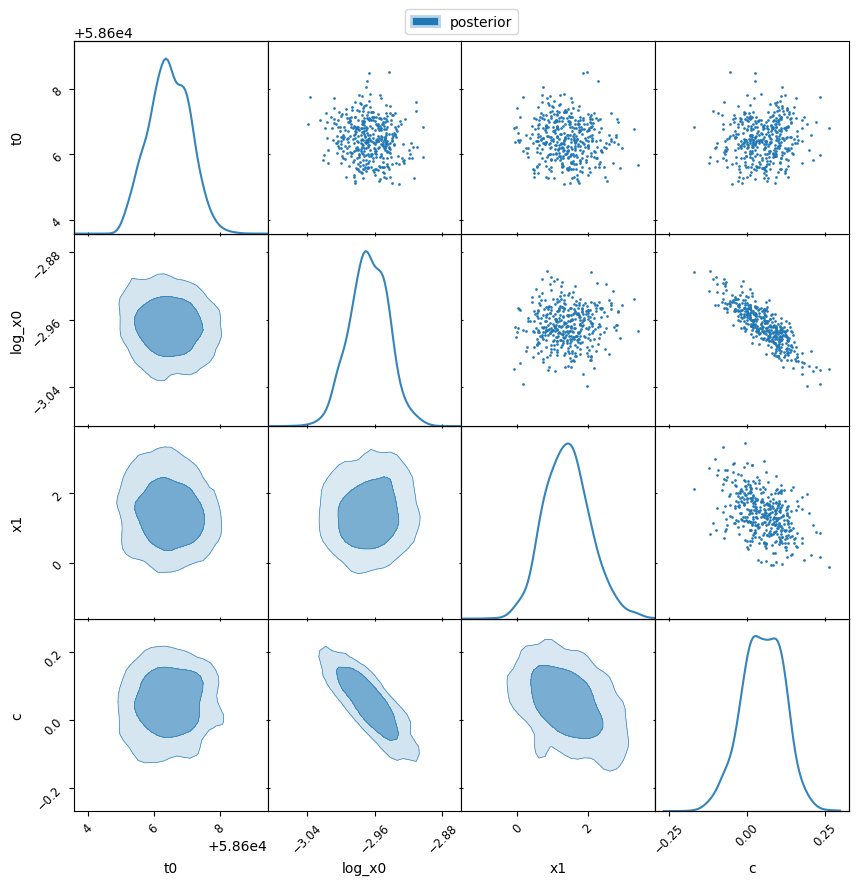

Corner plot saved as 'corner_plot.png'.


In [13]:
# Define parameter names based on whether redshift is fixed or sigma is fit
if fix_z:
    param_names = ['t0', 'log_x0', 'x1', 'c']
else:
    param_names = ['z', 't0', 'log_x0', 'x1', 'c']
if fit_sigma:
    param_names.append('log_sigma')

# Save the chains of dead points
save_chains_dead_birth(dead, param_names)

# Read the chains using anesthetic
samples = read_chains('chains/chains', columns=param_names)

# Create a corner plot of the posterior distributions
fig, axes = make_2d_axes(param_names, figsize=(10, 10), facecolor='w')
samples.plot_2d(axes, alpha=0.9, label="posterior")
axes.iloc[-1, 0].legend(bbox_to_anchor=(len(axes)/2, len(axes)), loc='lower center', ncols=2)

plt.savefig('corner_plot.png')
plt.show()

print("Corner plot saved as 'corner_plot.png'.")

## Parameter Statistics

Finally, we print a summary of the fitted parameters, showing the mean and standard deviation for each parameter based on the posterior samples.

In [14]:
print("\nParameter Statistics:")
print("-" * 50)
for param in param_names:
    mean = samples[param].mean()
    std = samples[param].std()
    print(f"{param}: {mean:.6f} ± {std:.6f}")


Parameter Statistics:
--------------------------------------------------
t0: 58606.474450 ± 0.606196
log_x0: -2.967038 ± 0.022591
x1: 1.427032 ± 0.647398
c: 0.050179 ± 0.066179
